# Full Model Training and Tuning

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random

np.random.seed(1)

%matplotlib inline

### Load in data from arrays

In [2]:
ProcFeats = np.load('Arrays/FeatsArray.npy')
ProcLabels = np.load('Arrays/LabelsList.npy')
featureNames = np.load('Arrays/FeatureNames.npy')

## Train Classifier Model

In [3]:
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection

#### Validation

Stratified k-fold cross validation

In [4]:
k_fold = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

#### Classifier Model

One vs. Rest : Random Forest

In [5]:
clf = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier(n_estimators=80, random_state=1))

## Classifier Model Analysis

#### Model Scoring : Confusion Matrix & Recall Score

In [6]:
# Train/Test Validation
X_train, X_test, y_train, y_test_true = sklearn.model_selection.train_test_split(ProcFeats,\
                                                            ProcLabels, test_size=0.25, random_state=1)

BestfitModel = clf.fit(X_train,y_train)

In [7]:
# Deterministic predictions
y_test_pred = BestfitModel.predict(X_test)

# Probablistic predictions
y_class_probs = BestfitModel.predict_proba(X_test)

In [8]:
# Get Recall Scores
WeightedRecallScore = sklearn.metrics.recall_score(y_test_true, y_test_pred, labels=[10,11], average='weighted')
HighDMRecall = sklearn.metrics.recall_score(y_test_true, y_test_pred, average=None)[11]
LowDMRecall = sklearn.metrics.recall_score(y_test_true, y_test_pred, average=None)[10]

# Print scores
print('Weighted recall score : ', WeightedRecallScore)
print('High DM recall score : ', HighDMRecall)
print('Low DM recall score : ', LowDMRecall)

Weighted recall score :  0.9764150943396226
High DM recall score :  0.9583333333333334
Low DM recall score :  0.9801136363636364


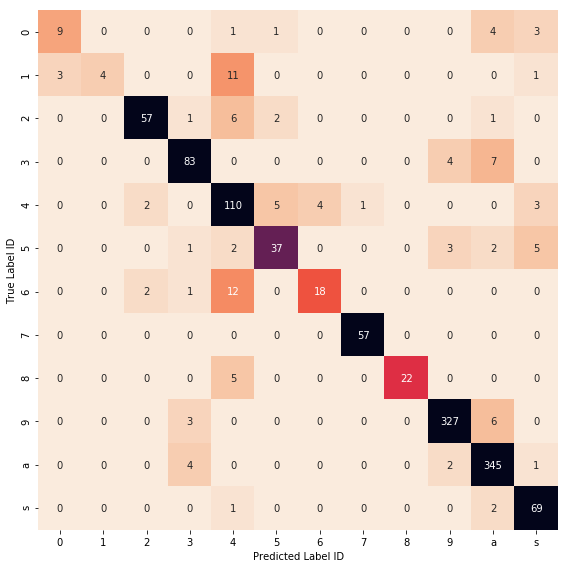

In [9]:
# Get confusion matrix
confuseMatrix = sklearn.metrics.confusion_matrix(y_test_true, y_test_pred)

# Plot confusion matrix
classLabels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 's']
    
dfCM = pd.DataFrame(confuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])

fig = plt.figure(figsize=(8,8)) # (width, height)
sns.heatmap(dfCM, annot=True, cmap=sns.cm.rocket_r, vmin=0, vmax=50, fmt='d', cbar=False)
plt.xlabel('Predicted Label ID')
plt.ylabel('True Label ID')

plt.tight_layout()

### Test the effect of changing threshold

In [10]:
testScores = np.array(y_class_probs)

# lists of probabilities of being in classes 10 and 11
lowDMpulses = list(testScores[:,10])
highDMpulses = list(testScores[:,11])

y_test_pred_thresh = y_test_pred.copy()

In [11]:
def SetThreshold(threshold):
   
    # reset predictions
    y_test_pred_thresh = BestfitModel.predict(X_test)

    # Low DM threshold
    for i in lowDMpulses:
        if i >= threshold:
            pulseIndex = lowDMpulses.index(i)
            if y_test_pred_thresh[pulseIndex] == 11 and lowDMpulses[pulseIndex] < highDMpulses[pulseIndex]:
                pass
            elif y_test_pred_thresh[pulseIndex] == 11 and lowDMpulses[pulseIndex] > highDMpulses[pulseIndex]:
                y_test_pred_thresh[pulseIndex] = 10
            else:
                y_test_pred_thresh[pulseIndex] = 10
    
    # High DM threshold
    for i in highDMpulses:
        if i >= threshold:
            pulseIndex = highDMpulses.index(i)
            if y_test_pred_thresh[pulseIndex] == 10 and highDMpulses[pulseIndex] < lowDMpulses[pulseIndex]:
                pass
            elif y_test_pred_thresh[pulseIndex] == 10 and highDMpulses[pulseIndex] > lowDMpulses[pulseIndex]:
                 y_test_pred_thresh[pulseIndex] = 11
            else:
                y_test_pred_thresh[pulseIndex] = 11
            
    # get recall and precision scores
    recall = sklearn.metrics.recall_score(y_test_true, y_test_pred_thresh, labels=[10,11], average='weighted')
    precision = sklearn.metrics.precision_score(y_test_true, y_test_pred_thresh, labels=[10,11], average='weighted')
    recall10 = sklearn.metrics.recall_score(y_test_true, y_test_pred_thresh, average=None)[10]
    precision10 = sklearn.metrics.precision_score(y_test_true, y_test_pred_thresh, average=None)[10]
    recall11 = sklearn.metrics.recall_score(y_test_true, y_test_pred_thresh, average=None)[11]
    precision11 = sklearn.metrics.precision_score(y_test_true, y_test_pred_thresh, average=None)[11]
    
            
    return y_test_pred_thresh, recall, precision, recall10, precision10, recall11, precision11

In [12]:
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
testRecallScores = []
testPrecisionScores = []
recall10 = []
precision10 = []
recall11 = []
precision11 = []

for i in thresholds:
    y_pred, recall, precision, recall10only, precision10only, recall11only, precision11only = SetThreshold(i)
    testRecallScores.append(recall)
    testPrecisionScores.append(precision)
    recall10.append(recall10only)
    precision10.append(precision10only)
    recall11.append(recall11only)
    precision11.append(precision11only)

In [13]:
binaryRecalls = np.load('Arrays/BinaryRecallScores.npy')
binaryPrecisions = np.load('Arrays/BinaryPrecisionScores.npy')

In [14]:
print(binaryRecalls)

[0.96462264 0.96226415 0.95990566 0.95990566 0.95990566 0.95990566
 0.95754717 0.95283019 0.94575472]


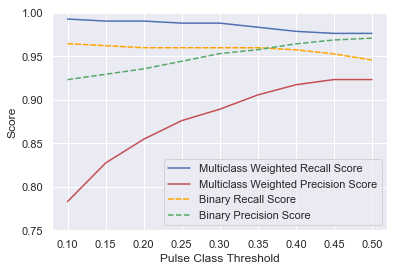

In [15]:
sns.set(style='darkgrid')
plt.plot(thresholds, testRecallScores, 'b', label='Multiclass Weighted Recall Score')
plt.plot(thresholds, testPrecisionScores, 'r', label='Multiclass Weighted Precision Score')
plt.plot(thresholds, binaryRecalls, color='orange',dashes=[4,1], label='Binary Recall Score')
plt.plot(thresholds, binaryPrecisions, 'g--', label='Binary Precision Score')
plt.legend()
plt.ylim(0.75,1)
plt.xlabel('Pulse Class Threshold')
plt.ylabel('Score')
plt.show()

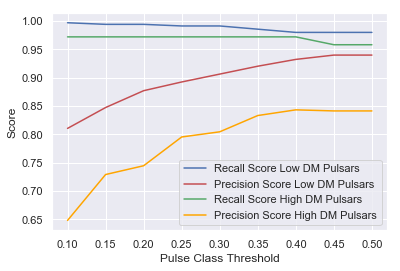

In [16]:
sns.set(style='darkgrid')
plt.plot(thresholds, recall10, 'b', label='Recall Score Low DM Pulsars')
plt.plot(thresholds, precision10, 'r', label='Precision Score Low DM Pulsars')
plt.plot(thresholds, recall11, 'g', label='Recall Score High DM Pulsars')
plt.plot(thresholds, precision11, color='orange', label='Precision Score High DM Pulsars')

plt.legend()
plt.xlabel('Pulse Class Threshold')
plt.ylabel('Score')
plt.show()

In [17]:
cl_a, cl_b = 5,11
X_ab = X_test[(y_test_true == cl_a) & (y_test_pred == cl_b)]
X_ba = X_test[(y_test_true == cl_b) & (y_test_pred == cl_a)]
X_bb = X_test[(y_test_true == cl_b) & (y_test_pred == cl_b)]
X_aa = X_test[(y_test_true == cl_a) & (y_test_pred == cl_a)]

In [18]:
indexlist = []
wrongplots = []
df = pd.read_pickle('DataFrames/FullTrainFeatsDF.pkl')


for i in X_ba:
    match = np.where((ProcFeats == i).all(axis=1))
    match = match[0][0]
    indexlist.append(match)
    

for i in indexlist:
    plot = df.index[i]
    wrongplots.append(plot)
    
print(indexlist)    
print(wrongplots)

[]
[]


0 posPeaks5std 0.022361676282782746
1 windDedispTimeSeriesstd5 0.014117117655495356
2 pixelsmax_2_0 0.02776976707231541
3 MJDmin 0.04449631208567899
4 globalDedispTimeStatsstd 0.03139897572616252
5 globalDedispTimeStatsmax 0.05092045006002255
6 globalDedispTimeStatsnegPct 0.025537191271179944
7 globalTimeStatsmin 0.10533210338503204
8 pixelsmin_4_0 0.03983670503095063
9 BestDM 0.07915615247863847
a DMmax 0.0640814403044297
s DMmax 0.0507700844292025


Text(0,0.5,'Feature Importance')

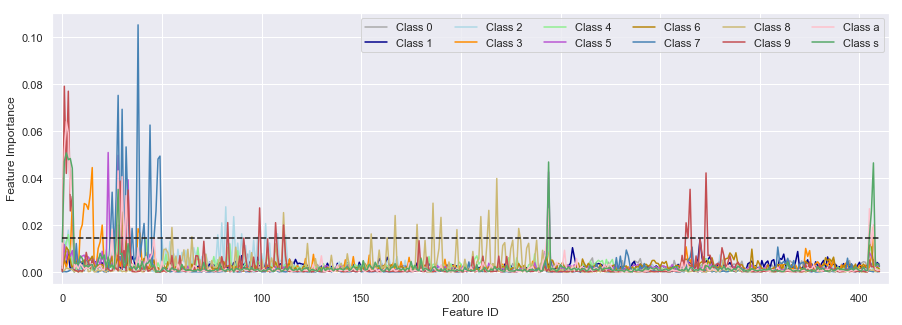

In [19]:
fig = plt.figure(figsize=(15,5)) # (width, height)
sns.set(style='darkgrid')
for idx in np.arange(len(BestfitModel.estimators_)):
    maxFeatVal = BestfitModel.estimators_[idx].feature_importances_.max()
    if classLabels[idx] == '9':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, 'r', label='Class '+classLabels[idx])
    elif classLabels[idx] == '2':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='lightblue', label='Class '+classLabels[idx])
    elif classLabels[idx] == '8':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='y', label='Class '+classLabels[idx])
    elif classLabels[idx] == 's':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='g', label='Class '+classLabels[idx])
    elif classLabels[idx] == '0':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='darkgrey', label='Class '+classLabels[idx])
    elif classLabels[idx] == '1':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='darkblue', label='Class '+classLabels[idx])
    elif classLabels[idx] == '3':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='darkorange', label='Class '+classLabels[idx])
    elif classLabels[idx] == '4':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='lightgreen', label='Class '+classLabels[idx])
    elif classLabels[idx] == '5':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='mediumorchid', label='Class '+classLabels[idx])
    elif classLabels[idx] == '6':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='darkgoldenrod', label='Class '+classLabels[idx])
    elif classLabels[idx] == '7':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='steelblue', label='Class '+classLabels[idx])
    elif classLabels[idx] == 'a':
        plt.plot(BestfitModel.estimators_[idx].feature_importances_, color='pink', label='Class '+classLabels[idx])
   
    plt.xlim(-5,415)
    print(classLabels[idx], featureNames[np.argmax(BestfitModel.estimators_[idx].feature_importances_)], maxFeatVal)

    
cutofflist = [i for i in range(0,411)]
cutoff = [0.0146]*411
plt.plot(cutofflist, cutoff, 'k--')
    
plt.legend(loc='upper right', ncol=6 )
plt.xlabel('Feature ID')
plt.ylabel('Feature Importance')

# Predict classes of full data set

In [20]:
TestProcFeats = np.load('Arrays/TestFeatsArray.npy')
TestfeatureNames = np.load('Arrays/FeatureNames.npy')

In [21]:
PredictedClasses = BestfitModel.predict(TestProcFeats)
PredClassProbs = BestfitModel.predict_proba(TestProcFeats)

### Determine how many events in each class label

In [22]:
TestDF = pd.read_pickle('DataFrames/FullTestFeatsDF.pkl')

In [23]:
def GetClassCount(classNumber):
    
    indexlist = list(np.where(PredictedClasses == classNumber))
    
    Events = []
    for i in indexlist:
        event = TestDF.index[i]
        Events.append(event)
    
    Events = list(Events)
    
    # How many events in class
    classCount = len(Events[0])
    
    return classCount, Events

In [24]:
Class0Counts, Class0List = GetClassCount(0)
Class1Counts, Class1List = GetClassCount(1)
Class2Counts, Class2List = GetClassCount(2)
Class3Counts, Class3List = GetClassCount(3)
Class4Counts, Class4List = GetClassCount(4)
Class5Counts, Class5List = GetClassCount(5)
Class6Counts, Class6List = GetClassCount(6)
Class7Counts, Class7List = GetClassCount(7)
Class8Counts, Class8List = GetClassCount(8)
Class9Counts, Class9List = GetClassCount(9)
Class10Counts, Class10List = GetClassCount(10)
Class11Counts, Class11List = GetClassCount(11)

In [25]:
TestLabelCounts = [Class0Counts,Class1Counts,Class2Counts,Class3Counts,Class4Counts,Class5Counts,Class6Counts,Class7Counts,Class8Counts,Class9Counts,Class10Counts,Class11Counts]

In [26]:
total = 0
for i in TestLabelCounts:
    print('Class', TestLabelCounts.index(i),' : ', i)
    total += i
    
print('Total : ', total)

Class 0  :  161
Class 1  :  1
Class 2  :  1949
Class 3  :  4263
Class 4  :  22900
Class 5  :  3299
Class 6  :  525
Class 7  :  7573
Class 8  :  1345
Class 9  :  17988
Class 10  :  49777
Class 11  :  6702
Total :  116483


In [27]:
np.save('Arrays/Class0Events.npy', Class0List)
np.save('Arrays/Class11Events.npy', Class11List)

In [28]:
testScores1 = np.array(PredClassProbs)

# lists of probabilities of being in classes 10 and 11
lowDMpulses1 = list(testScores1[:,10])
highDMpulses1 = list(testScores1[:,11])

In [29]:
def SetTestThreshold(threshold):
   
    # reset predictions
    y_test_pred_thresh = BestfitModel.predict(TestProcFeats)

    
    # High DM threshold
    for i in highDMpulses1:
        if i >= threshold:
            pulseIndex = highDMpulses1.index(i)
            y_test_pred_thresh[pulseIndex] = 11
    
    return y_test_pred_thresh

In [30]:
TestThresh01 = SetTestThreshold(0.1)

In [31]:
def GetTestClassCount(classNumber):
    
    indexlist = list(np.where(TestThresh01 == classNumber))
    
    Events = []
    for i in indexlist:
        event = TestDF.index[i]
        Events.append(event)
    
    Events = list(Events)
    
    # How many events in class
    classCount = len(Events[0])
    
    return classCount, Events

In [32]:
LowThresh11Counts, LowThresh11List = GetTestClassCount(11)

In [33]:
print(LowThresh11Counts)

6979


In [34]:
testList = list(LowThresh11List[0])
oldList = list(Class11List[0])
LowThreshEvents = []
for i in testList:
    if i in oldList:
        pass
    else:
        LowThreshEvents.append(i)
        
print(len(LowThreshEvents))

277


In [35]:
np.save('Arrays/LowThreshEvents.npy', LowThreshEvents)

In [36]:
print(LowThreshEvents)

['Beam1_dm_D20160731T095710_block1.png', 'Beam1_dm_D20170129T170842_block1.png', 'Beam1_dm_D20160221T191927_block1.png', 'Beam1_dm_D20160513T224504_block1.png', 'Beam1_dm_D20170402T192806_block1.png', 'Beam1_dm_D20170421T230801_block1.png', 'Beam1_dm_D20131112T081743_block3.png', 'Beam1_dm_D20151016T172009_block1.png', 'Beam1_dm_D20161002T074449_block1.png', 'Beam1_dm_D20170120T171655_block1.png', 'Beam1_dm_D20160807T092658_block1.png', 'Beam1_dm_D20170416T091935_block1.png', 'Beam1_dm_D20170311T045226_block1.png', 'Beam2_dm_D20161211T024854_block1.png', 'Beam2_dm_D20170507T212318_block2.png', 'Beam2_dm_D20170506T075743_block1.png', 'Beam2_dm_D20170129T170842_block1.png', 'Beam2_dm_D20161203T065820_block1.png', 'Beam2_dm_D20160522T133150_block1.png', 'Beam2_dm_D20170113T134012_block1.png', 'Beam2_dm_D20150220T123009_block1.png', 'Beam2_dm_D20160214T164629_block1.png', 'Beam2_dm_D20161125T200136_block1.png', 'Beam2_dm_D20150726T063825_block1.png', 'Beam2_dm_D20161118T223300_block1.png',

In [37]:
allPulsars = list(Class10List[0]) + list(Class11List[0])
allPulsars = list(allPulsars)
print(len(allPulsars))
pulsars = TestDF.loc[allPulsars]

56479


621


Text(0,0.5,'Number')

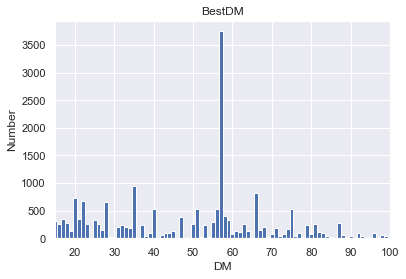

In [43]:
binNum = int(TestDF['BestDM'].max())
print(binNum)
TestDF.hist('BestDM', bins=np.arange(14.5,100,1))
plt.xlim(15,100)
plt.xlabel('DM')
plt.ylabel('Number')